In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import cv2
from tqdm import tqdm

%matplotlib inline
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
from collections import Counter

import kagglehub
import os
from PIL import Image

In [2]:
# Download latest version
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")
print("Path to dataset files:", path)

os.system("kaggle datasets download jehanbhathena/weather-dataset --unzip -p ./dataset")

Path to dataset files: /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3


0

In [3]:
image_size = 224
batch_size = 32
num_workers = 2
learning_rate = 1e-4
num_epoch = 100

In [4]:
tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomRotation(10),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
    ])
tf_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()

    ])


In [5]:
dataset = datasets.ImageFolder('/content/dataset/dataset', transform=None)

In [6]:
train_set, test_set = random_split(dataset=dataset,lengths=[0.8,0.2])

In [7]:
os.makedirs('./dataset/train', exist_ok=True)
os.makedirs('./dataset/test', exist_ok=True)

In [8]:
def save_split_dataset(dataset, folder):
    for i, (image, label) in enumerate(dataset):
        class_dir = os.path.join(folder, dataset.dataset.classes[label])
        os.makedirs(class_dir, exist_ok=True)  # Create class subdirectory if it doesn't exist
        image_path = os.path.join(class_dir, f'image_{i}.jpg')  # Change the filename as needed
        image.save(image_path)  # Save the image to the directory

# Save training and testing datasets
save_split_dataset(train_set, './dataset/train')
save_split_dataset(test_set, './dataset/test')


In [9]:
# Step 6: Load the split datasets with transforms
train_set = datasets.ImageFolder('./dataset/train', transform=tf_train)
test_set = datasets.ImageFolder('./dataset/test', transform=tf_test)

# Create DataLoaders for both datasets
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [10]:
# Function to count samples per class
# def count_samples_per_class(dataset):
#     labels = [label for _, label in dataset]
#     label_count = Counter(labels)
#     return label_count

In [11]:
# label_count = count_samples_per_class(train_set)
# num_classes = len(label_count)
# print("Total number of data: ", len(train_set))
# print("Number of classes:", num_classes)
# print("Number of data samples per class:", label_count)

In [12]:
# label_count = count_samples_per_class(test_set)
# num_classes = len(label_count)
# print("Total number of data: ", len(test_set))
# print("Number of classes:", num_classes)
# print("Number of data samples per class:", label_count)

In [13]:
cat_to_name = {'1': 'dew', '2': 'fogsmog', '3': 'frost', '4':'glaze', '5':'hail', '6':'lightning', '7':'rain', '8':'rainbow', '9':'rime', '10':'sandstorm', '11':'snow'}

def imshow(img_tensor, ax, label):
    """ Utility function to display an image tensor with a caption. """
    img_tensor = img_tensor.clamp(0, 1)  # Ensure values are in the range [0, 1] for floating point
    if img_tensor.shape[0] == 3:  # Check if it's an RGB image
        ax.imshow(img_tensor.permute(1, 2, 0))  # Reorder dimensions to (height, width, channels)
    else:
        ax.imshow(img_tensor[0], cmap='gray')  # Display the first channel (grayscale)
    ax.axis('off')
    ax.set_title(label, fontsize=10)

def show_images_batch(images_batch, labels):
    """
    Display a batch of images in a grid with labels.
    """

    batch_size = images_batch.shape[0]
    grid_cols = int(np.ceil(np.sqrt(batch_size)))
    grid_rows = int(np.ceil(batch_size / grid_cols))  # Ensure all images fit in the grid

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 1.5, grid_rows * 1.5))
    axes = np.atleast_1d(axes)  # Ensure axes are always iterable

    for i in range(grid_rows * grid_cols):
        ax = axes.flatten()[i]
        if i < batch_size:
            imshow(images_batch[i], ax, cat_to_name[str(labels[i].item() + 1)])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


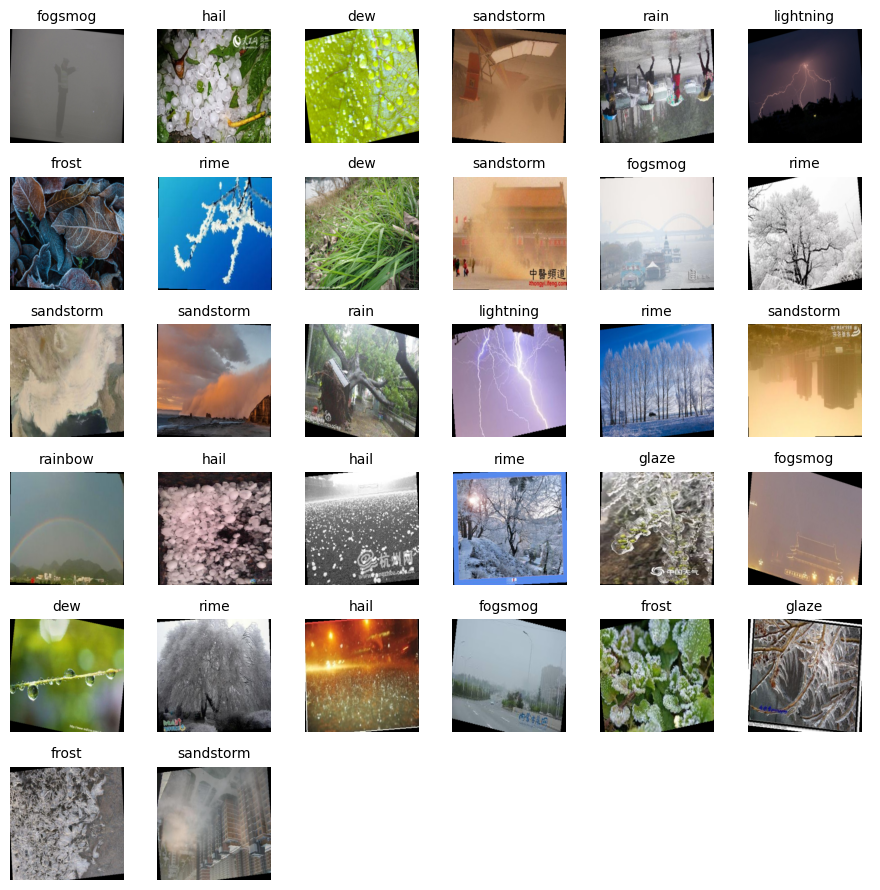

In [14]:
for idx, data in enumerate(train_loader):

  show_images_batch(images_batch=data[0], labels=data[1])
  break

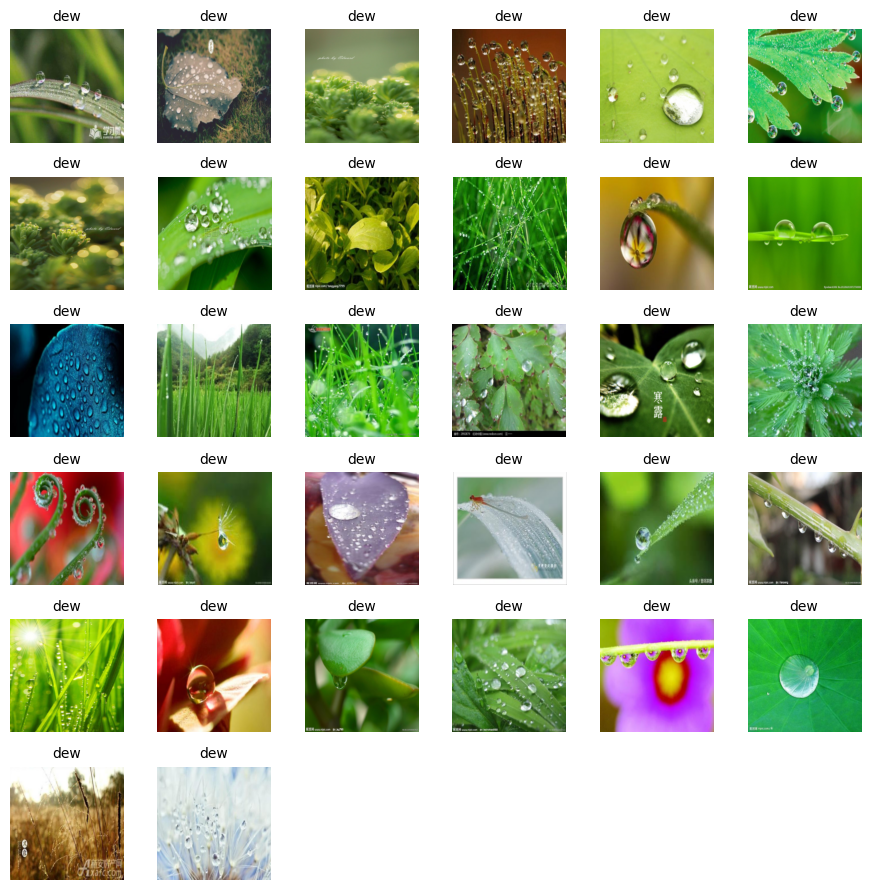

In [15]:
for idx, data in enumerate(test_loader):

  show_images_batch(images_batch=data[0], labels=data[1])
  break

### CNN Model

In [16]:
convnext_tiny = models.convnext_tiny(weights='IMAGENET1K_V1').cuda()

In [17]:
summary(convnext_tiny, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

In [18]:
# close all the parameter to be trained
for p in convnext_tiny.parameters():
  p.requires_grad = False

In [19]:
for n,p in convnext_tiny.named_parameters():
  # print(n)
  if 'features.1' in n or 'features.4' in n :
    p.requires_grad = True

In [20]:
# convnext_tiny.features[-1].shape()

In [21]:
summary(convnext_tiny, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

In [22]:
num_class = 11

class CNNModel(nn.Module):

  def __init__(self, image_depth):

    super().__init__()
    self.convnext_tiny = convnext_tiny

    self.fc1 = nn.Linear(in_features=1000,out_features=512)
    self.fc2 = nn.Linear(in_features=512,out_features=128)
    self.fc3 = nn.Linear(in_features=128,out_features=32)
    self.out = nn.Linear(in_features=32,out_features=num_class)

  def forward(self, x):
    x = self.convnext_tiny(x)

    #fully-connected classifiers.
    x = torch.flatten(x, start_dim=1) #we need to all the dimensions except the batch. 0 is batch
    x = F.relu(self.fc1(x))
    x = F.dropout(x,p=0.45)
    x = F.relu(self.fc2(x))
    x = F.dropout(x,p=0.25)
    x = F.relu(self.fc3(x))
    x = F.dropout(x,p=0.1)
    x = self.out(x)

    return x

In [23]:
model = CNNModel(3)
model = model.cuda()

In [24]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

In [25]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [26]:
best_val_accuracy = 0
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
all_preds = []
all_labels = []
# for epoch_idx in range(num_epoch):
for epoch_idx in range(15):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  # Store the average training loss and accuracy for the current epoch
  train_loss_history.append(train_running_loss)
  train_acc_history.append(train_running_accuracy/(idx+1))

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")


327it [04:35,  1.19it/s]


Training Loss at epoch 0 is 449.2236394584179
Training Accuracy at epoch 0 is 0.5599961773700306


327it [04:34,  1.19it/s]


Training Loss at epoch 1 is 195.50858561694622
Training Accuracy at epoch 1 is 0.80625


327it [04:35,  1.18it/s]


Training Loss at epoch 2 is 147.12810607254505
Training Accuracy at epoch 2 is 0.8595948012232415


327it [04:34,  1.19it/s]


Training Loss at epoch 3 is 120.99684121459723
Training Accuracy at epoch 3 is 0.8849197247706422


327it [04:39,  1.17it/s]


Training Loss at epoch 4 is 101.93125009164214
Training Accuracy at epoch 4 is 0.9015290519877677


327it [04:34,  1.19it/s]


Training Loss at epoch 5 is 96.48595716431737
Training Accuracy at epoch 5 is 0.9079510703363913


327it [04:32,  1.20it/s]


Training Loss at epoch 6 is 82.84693690389395
Training Accuracy at epoch 6 is 0.9197247706422018


327it [04:32,  1.20it/s]


Training Loss at epoch 7 is 78.26905110478401
Training Accuracy at epoch 7 is 0.9243883792048929


327it [04:32,  1.20it/s]


Training Loss at epoch 8 is 70.37182359583676
Training Accuracy at epoch 8 is 0.9329128440366973


327it [04:31,  1.21it/s]


Training Loss at epoch 9 is 64.57557565718889
Training Accuracy at epoch 9 is 0.9394113149847095


327it [04:32,  1.20it/s]


Training Loss at epoch 10 is 60.79321135394275
Training Accuracy at epoch 10 is 0.9413990825688072


327it [04:32,  1.20it/s]


Training Loss at epoch 11 is 57.040892569348216
Training Accuracy at epoch 11 is 0.946769877675841


327it [04:31,  1.20it/s]


Training Loss at epoch 12 is 50.52226778678596
Training Accuracy at epoch 12 is 0.9521980122324158


327it [04:30,  1.21it/s]


Training Loss at epoch 13 is 48.54258350841701
Training Accuracy at epoch 13 is 0.954032874617737


327it [04:30,  1.21it/s]

Training Loss at epoch 14 is 46.03942581824958
Training Accuracy at epoch 14 is 0.9563264525993884


In [27]:
for epoch_idx in range(15):
  val_running_loss = 0.0
  val_running_accuracy = 0.0
  idx = 0
  for idx, data in tqdm(enumerate(test_loader)):

    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = model(images)
    loss = loss_fn(pred, labels)

    val_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()
    all_preds.append(pred_arr.cpu().numpy())  # Move to CPU and convert to numpy
    all_labels.append(labels.cpu().numpy())   # Move to CPU and convert to numpy

    val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  # Store the average validation loss and accuracy for the current epoch
  val_loss_history.append(val_running_loss)
  val_acc_history.append(val_running_accuracy/(idx+1))

  print(f"Validation Loss at epoch {epoch_idx} is {val_running_loss}")
  print(f"Validation Accuracy at epoch {epoch_idx} is {val_running_accuracy/(idx+1)}")

82it [00:22,  3.57it/s]


Validation Loss at epoch 0 is 15.864615715923719
Validation Accuracy at epoch 0 is 0.9426829268292682


82it [00:23,  3.54it/s]


Validation Loss at epoch 1 is 16.50194533081958
Validation Accuracy at epoch 1 is 0.9388719512195122


82it [00:22,  3.69it/s]


Validation Loss at epoch 2 is 16.724455300252885
Validation Accuracy at epoch 2 is 0.9369664634146341


82it [00:23,  3.56it/s]


Validation Loss at epoch 3 is 16.442070337827317
Validation Accuracy at epoch 3 is 0.939329268292683


82it [00:22,  3.57it/s]


Validation Loss at epoch 4 is 16.81152989063412
Validation Accuracy at epoch 4 is 0.9378048780487805


82it [00:27,  2.98it/s]


Validation Loss at epoch 5 is 16.718580353655852
Validation Accuracy at epoch 5 is 0.9373475609756097


82it [00:23,  3.55it/s]


Validation Loss at epoch 6 is 16.554503032937646
Validation Accuracy at epoch 6 is 0.940015243902439


82it [00:22,  3.66it/s]


Validation Loss at epoch 7 is 15.539247329172213
Validation Accuracy at epoch 7 is 0.940015243902439


82it [00:23,  3.44it/s]


Validation Loss at epoch 8 is 17.007886115112342
Validation Accuracy at epoch 8 is 0.9388719512195122


82it [00:23,  3.54it/s]


Validation Loss at epoch 9 is 15.025656725862063
Validation Accuracy at epoch 9 is 0.9434451219512194


82it [00:23,  3.56it/s]


Validation Loss at epoch 10 is 16.34933346649632
Validation Accuracy at epoch 10 is 0.9423780487804879


82it [00:23,  3.53it/s]


Validation Loss at epoch 11 is 16.196065885509597
Validation Accuracy at epoch 11 is 0.9430640243902438


82it [00:22,  3.63it/s]


Validation Loss at epoch 12 is 16.548071730299853
Validation Accuracy at epoch 12 is 0.9411585365853659


82it [00:22,  3.59it/s]


Validation Loss at epoch 13 is 16.202565767336637
Validation Accuracy at epoch 13 is 0.9392530487804878


82it [00:22,  3.57it/s]

Validation Loss at epoch 14 is 16.92449617420789
Validation Accuracy at epoch 14 is 0.9392530487804878


### Performance

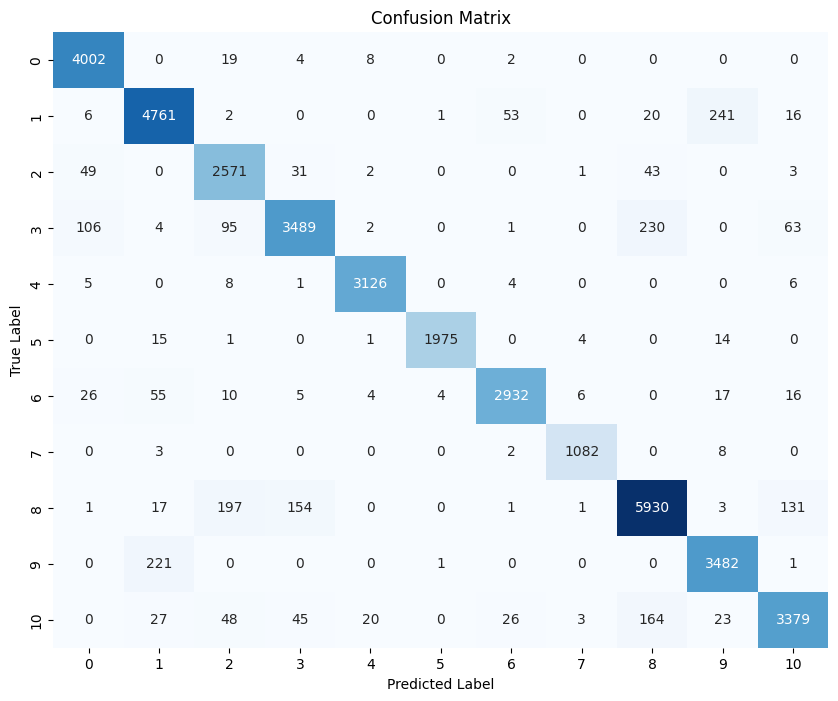

In [28]:
# Calculate average accuracy
val_running_accuracy /= (idx + 1)

# Concatenate all predictions and labels for confusion matrix
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(num_class), yticklabels=range(num_class))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

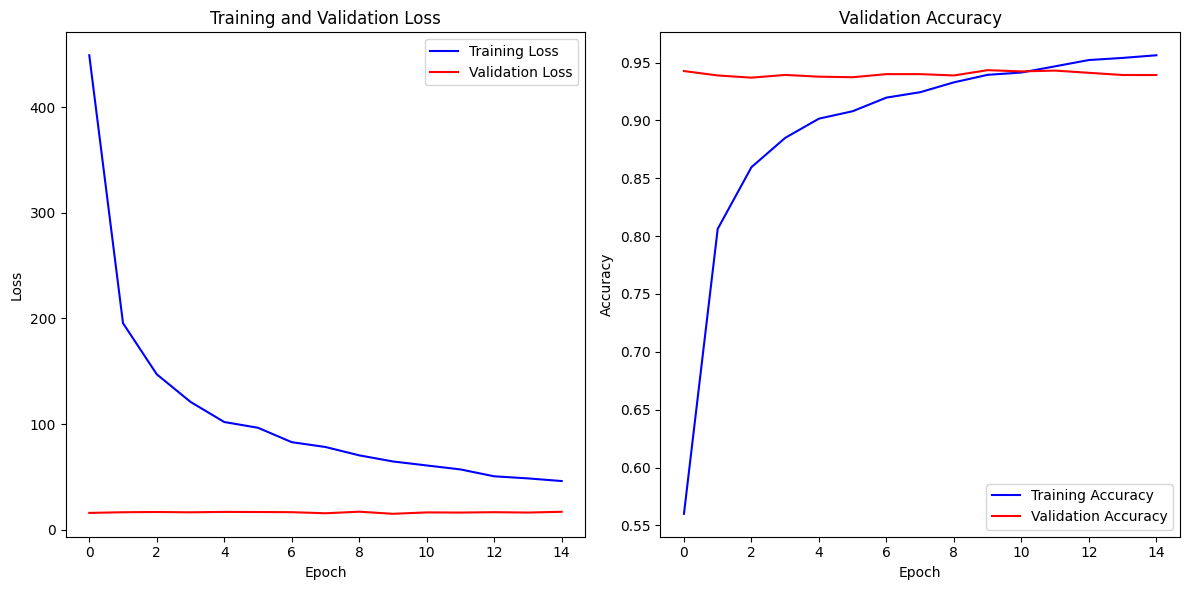

In [29]:
plt.figure(figsize=(12, 6))
num_epochs = len(train_loss_history)

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy', color='blue')
plt.plot(val_acc_history, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Overall Precision: 0.9471
Overall Recall: 0.9486
Overall F1-Score: 0.9475
Overall Accuracy: 0.9410


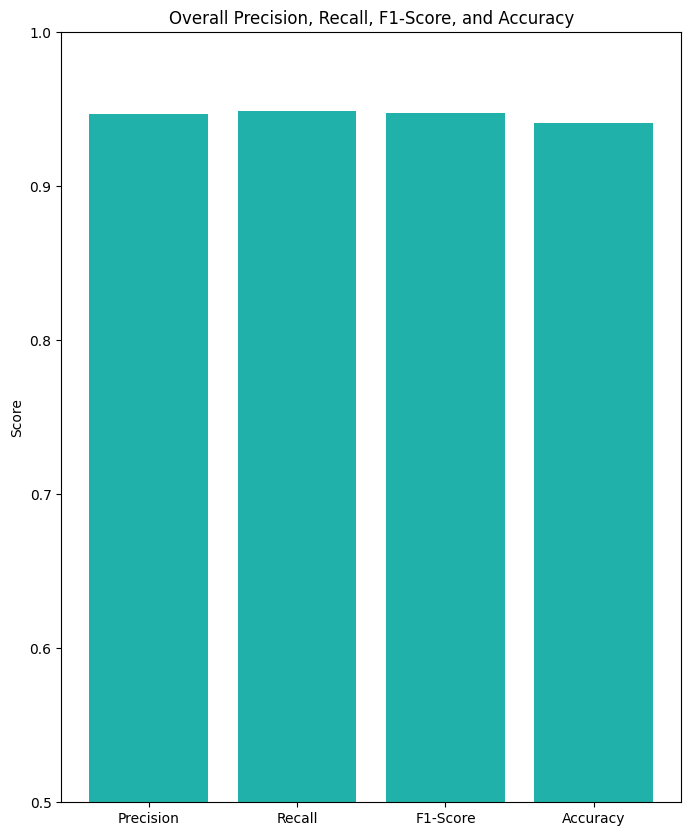

In [30]:
# Get precision, recall, f1-score, and support using classification_report
report = classification_report(all_labels, all_preds, output_dict=True)

# Extract overall precision, recall, f1-score from the 'macro avg' or 'weighted avg'
overall_precision = report['macro avg']['precision']
overall_recall = report['macro avg']['recall']
overall_f1_score = report['macro avg']['f1-score']
accuracy = report['accuracy']

# Print the overall metrics
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1_score:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

# Visualize the overall metrics as a bar plot
overall_metrics = {
    'Precision': overall_precision,
    'Recall': overall_recall,
    'F1-Score': overall_f1_score,
    'Accuracy': accuracy
}

plt.figure(figsize=(8, 10))
plt.bar(overall_metrics.keys(), overall_metrics.values(), color='lightseagreen')
plt.ylim(0.5, 1)
plt.title('Overall Precision, Recall, F1-Score, and Accuracy')
plt.ylabel('Score')
plt.show()

In [31]:
torch.save(model, 'convnextCNN_model.pth')
# torch.save(model.state_dict(), 'convnextCNN_model.pth')